In [5]:
import torch

import numpy as np
import torch.nn as nn

from architecture.WGN.pignn import FlowPIGNN


In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [7]:
# Load the data from a past experiment
case_nr = 1
max_angle = 30
seq_length = 1
wake_steering = True
use_graph = True

num_epochs = 300
early_stop_after = 12
output_size = 128*128

batch_size = 64
data_folder = f"../../Data/WGN_train_data"

model_cfg = {
        'edge_in_dim': 2,
        'node_in_dim': 4,
        'global_in_dim': 2,
        'n_pign_layers': 3,
        'edge_hidden_dim': 50,
        'node_hidden_dim': 50,
        'global_hidden_dim': 50,
        'num_nodes': 10,
        'residual': True,
        'input_norm': True,
        'pign_mlp_params': {
            'num_neurons': [256, 128],
            'hidden_act': 'ReLU',
            'out_act': 'ReLU'
        },
        'reg_mlp_params': {
            'num_neurons': [64, 128, 256],
            'hidden_act': 'ReLU',
            'out_act': 'ReLU'
        },
    }
 
train_cfg = {
    'max_angle': max_angle,
    'num_epochs': num_epochs,
    'use_graph': use_graph,
    'early_stop_after': early_stop_after,
    'batch_size': batch_size,
    'output_size': output_size,
}


In [8]:
def count_trainable_params(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)



In [9]:
test_loader_ = torch.load("test_loader")


graph_model = FlowPIGNN(**model_cfg).to(device)
graph_model.load_state_dict(torch.load("WGN_parameters/WGN_best.pt"))


graph_model.eval()

C:\Users\quiri\AppData\Local\Temp\ipykernel_26664\1296636056.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  test_loader_ = torch.load("test_loader")
C:\Users\quiri\AppD

FlowPIGNN(
  (gn_layers): ModuleList(
    (0): PIGN(
      (edge_model): MLP 
      Input Norm : BatchNorm1d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True) 
      Dimensions : [12, 256, 128, 50] 
      Hidden Act. : ReLU() 
      Out Act. : ReLU() 
      
      (node_model): MLP 
      Input Norm : BatchNorm1d(56, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True) 
      Dimensions : [56, 256, 128, 50] 
      Hidden Act. : ReLU() 
      Out Act. : ReLU() 
      
      (global_model): MLP 
      Input Norm : BatchNorm1d(102, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True) 
      Dimensions : [102, 256, 128, 50] 
      Hidden Act. : ReLU() 
      Out Act. : ReLU() 
      
    )
    (1-2): 2 x PIGN(
      (edge_model): MLP 
      Input Norm : BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True) 
      Dimensions : [200, 256, 128, 50] 
      Hidden Act. : ReLU() 
      Out Act. : ReLU() 
      
      (node_model)

In [10]:
from utils.visualization import animate_prediction_vs_real


criterion = nn.MSELoss()

with torch.no_grad():
    test_losses = []
    generated_img = []
    target_img = []
    
    for i, batch in enumerate(test_loader_):
        batch = batch.to(device)
        nf = torch.cat((batch.x.to(device), batch.pos.to(device)), dim=-1).float()
        ef = batch.edge_attr.to(device).float()
        gf = batch.global_feats.to(device).float()
        
        pred = graph_model(batch, nf, ef, gf)
        target = batch.y.to(device).reshape(-1, pred.size(1),128,128)
        
        test_loss = criterion(pred, target)
        test_losses.append(test_loss.item())
        
        if i==0:
            generated_img.append(pred)
            target_img.append(target)

print(f"test loss: {np.mean(test_losses)}")

FileNotFoundError: [Errno 2] No such file or directory: '../../Data/WGN_train_data\\graph_1_LuT2deg_internal_41240.pt'

In [23]:
count_trainable_params(graph_model)

1660076

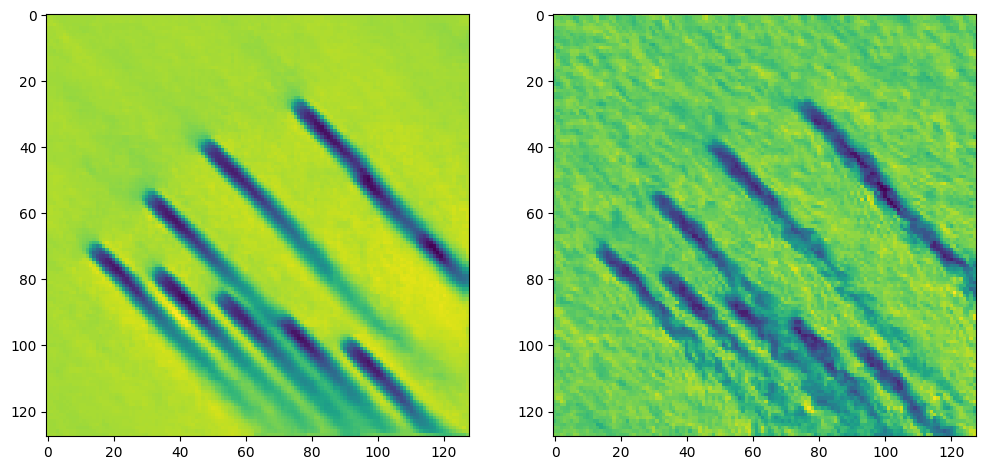

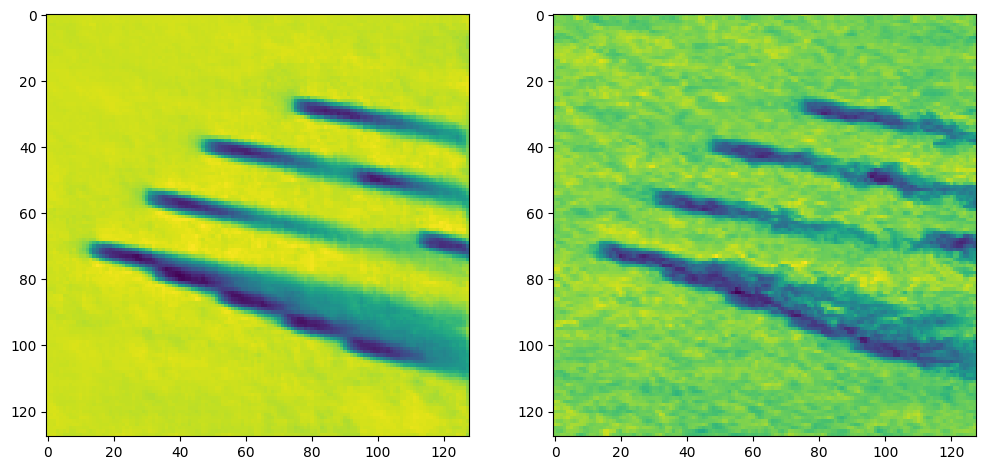

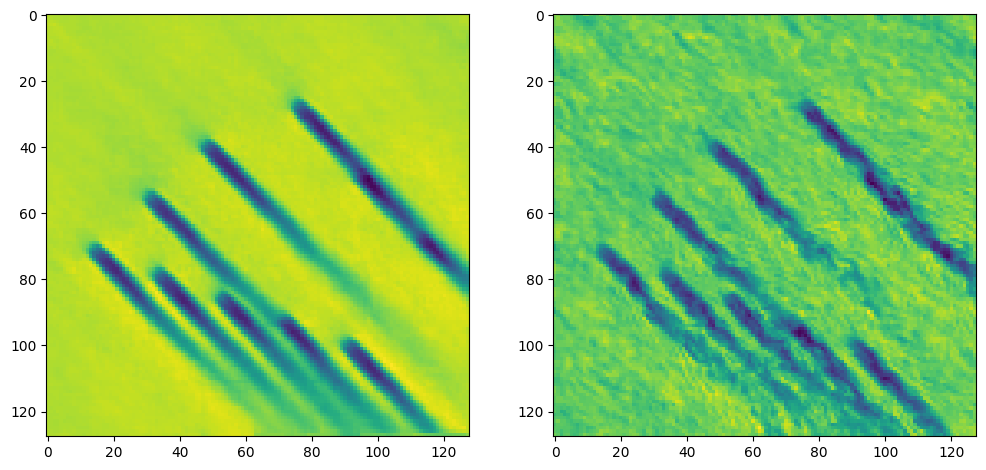

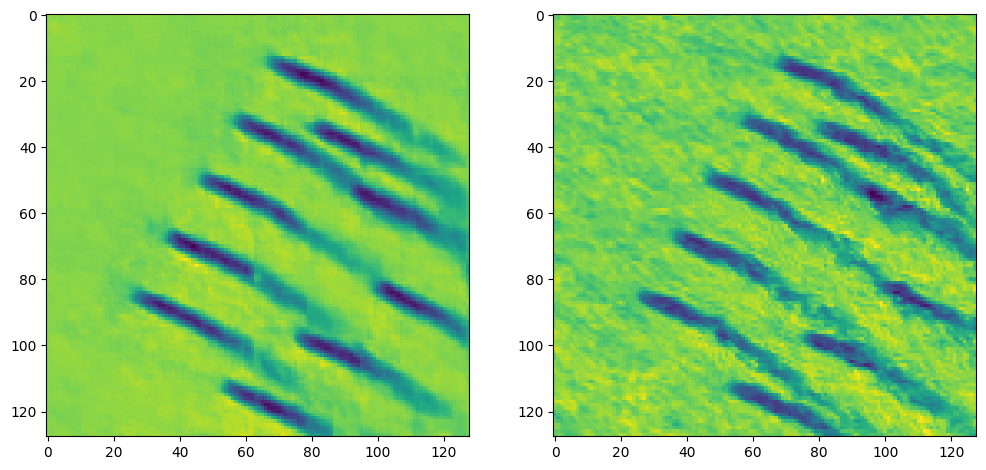

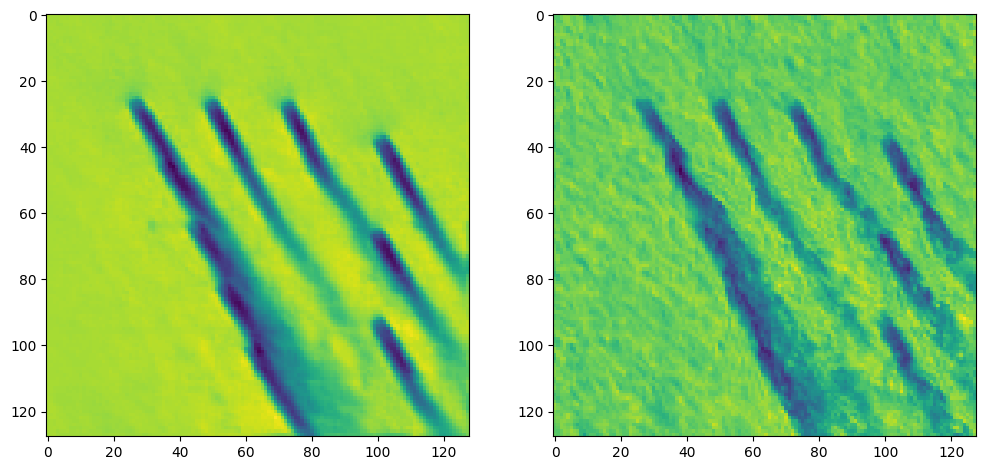

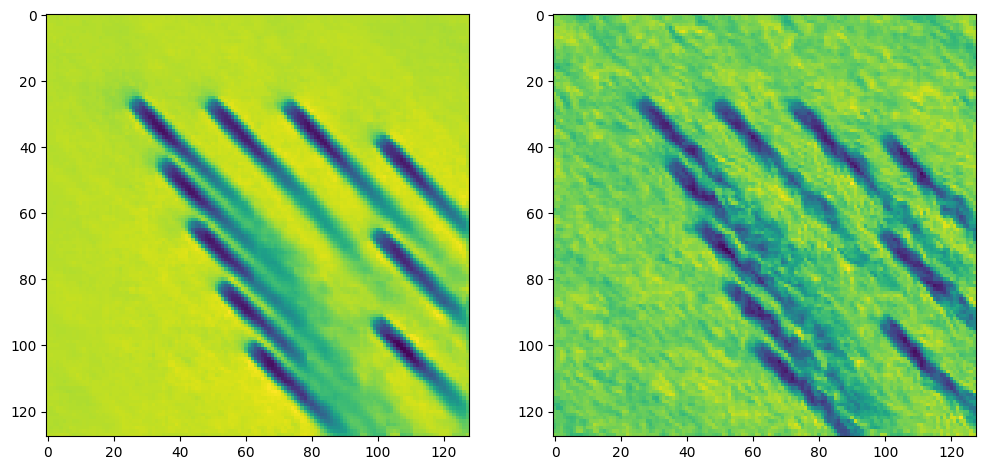

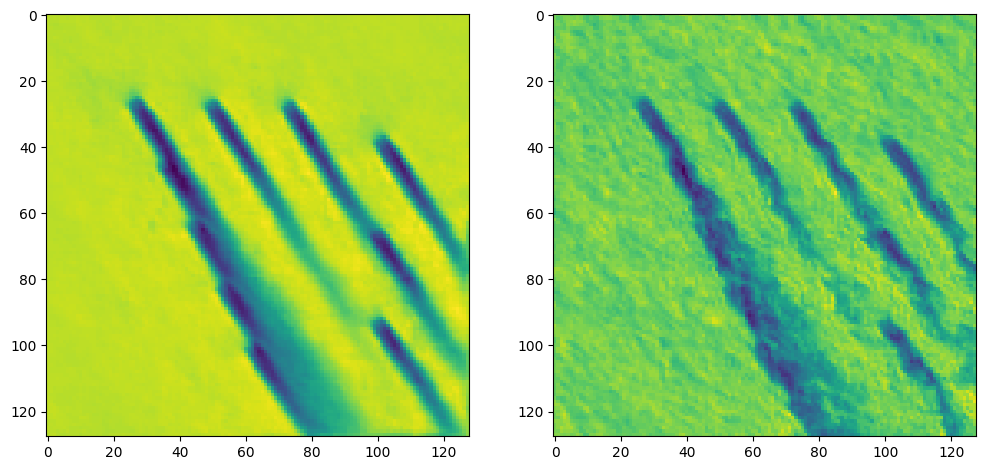

In [24]:
import matplotlib.pyplot as plt

ind = range(1,8)

for i in ind:
    plt.figure(figsize=(12,12))
    plt.subplot(1, 2, 1)
    plt.imshow(generated_img[0][i][0].cpu())
    plt.subplot(1, 2, 2)
    plt.imshow(target_img[0][i][0].cpu())
    plt.show()

In [50]:

from torch_geometric.data import Batch

def pred_graph(model, datapoint):
    # Create a "fake" batch of size 1 from the single Data point
    datapoint_batch = Batch.from_data_list([datapoint])
    
    # Extract the node features, edge features, and global features as you did before
    nf = torch.cat((datapoint_batch.x.to(device), datapoint_batch.pos.to(device)), dim=-1).float()
    ef = datapoint_batch.edge_attr.to(device).float()
    gf = datapoint_batch.global_feats.to(device).float()

    # Call the model
    pred = model(datapoint_batch.to(device), nf, ef, gf)

    return pred[0][0]



torch.Size([128, 128])


C:\Users\quiri\AppData\Local\Temp\ipykernel_20096\2358601719.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  datapoint = torch.load(f"../../Data/WGN_train_data/graph_{ca

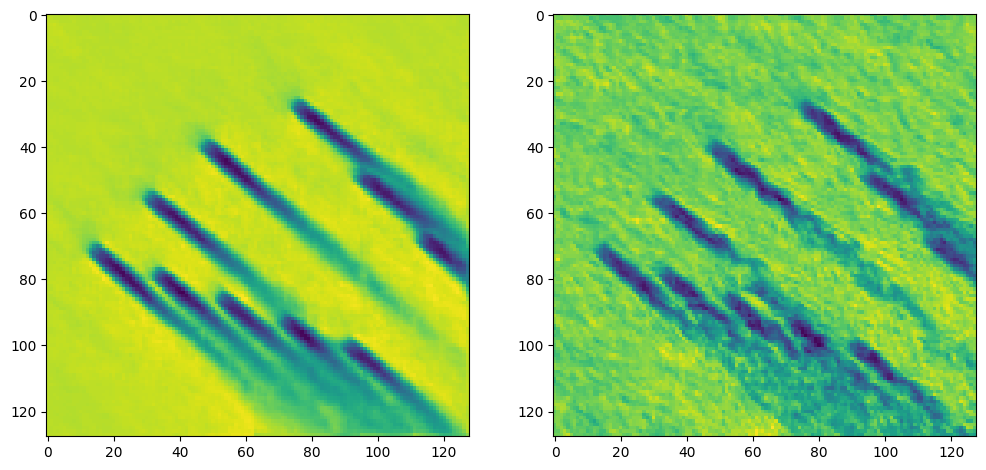

In [60]:
# Ensure model is in evaluation mode
case = 1
wake_steering = True
time = 34000

wake_steering = "LuT2deg_internal" if wake_steering else "BL"

datapoint = torch.load(f"../../Data/WGN_train_data/graph_{case}_{wake_steering}_{time}.pt")

graph_model.eval()

prediction = pred_graph(graph_model, datapoint)
target = datapoint.y.to(device).reshape(128,128)

plt.figure(figsize=(12,12))
plt.subplot(1, 2, 1)
plt.imshow(prediction.cpu().detach().numpy())
plt.subplot(1, 2, 2)
plt.imshow(target.cpu().detach().numpy())

DataBatch(x=[640, 2], edge_index=[2, 1038], edge_attr=[1038, 2], y=[1048576], pos=[640, 2], global_feats=[64, 2], batch=[640], ptr=[65])


TypeError: 'NoneType' object is not subscriptable